In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
from harvest_pole_env_br2 import HarvestPole_base
import numpy as np

from tf_agents.agents.dqn import dqn_agent

from tf_agents.environments import tf_py_environment

from tf_agents.policies import random_tf_policy
from tf_agents.networks import sequential
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import RandomUniform, Constant, VarianceScaling


In [2]:
py_env = HarvestPole_base()
py_env.bat.possible_init = py_env.bat.possible_init[1].reshape(1,3)
env = tf_py_environment.TFPyEnvironment(py_env)

In [3]:
fc_layer_params = (128, 128, 128, 64)
action_tensor_spec = tensor_spec.from_spec(py_env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

def dense_layer(num_units):
    dense_net  = tf.keras.layers.Dense(
        num_units,
        activation=tf.keras.activations.relu,
        kernel_initializer=VarianceScaling(
            scale=2.0, mode='fan_in', distribution='truncated_normal'))
    return dense_net

In [4]:
dense_net = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = Dense(
    num_actions,
    activation=None,
    kernel_initializer=RandomUniform(
        minval=-0.05, maxval=0.05),
    bias_initializer=Constant(-0.2))
q_net = sequential.Sequential(dense_net + [q_values_layer])

In [5]:
num_iterations = 500000

initial_collection_steps = 200
collect_steps_per_iteration = 1
replay_buffer_max_length = 50000

batch_size = 512
learning_rate = 1e-4
log_interval = 1000

num_eval_episodes = 10
eval_interval = 5000

In [6]:
eval_py_env = HarvestPole_base()
eval_py_env.bat.possible_init = eval_py_env.bat.possible_init[1].reshape(1,3)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [7]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    env.time_step_spec(),
    env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    epsilon_greedy = 0.5,
    n_step_update = 1,
    gamma = 0.8,
    td_errors_loss_fn = common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [8]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [9]:
def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0
    for episode in range(num_episodes):
        time_step = environment._reset()
        episode_return = 0
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment._step(action_step.action)
            episode_return += time_step.reward
        else:
            #print('ep={0}, return={1}'.format(episode, episode_return.numpy()[0]))
            total_return += episode_return
        avg_return = total_return/num_episodes
    return avg_return.numpy()[0]

In [10]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=env.batch_size,
    max_length=replay_buffer_max_length)

In [11]:
def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    
    buffer.add_batch(traj)

In [12]:
def collect_data(environment, policy, buffer, steps):
    for _ in range(steps):
        collect_step(environment, policy, buffer)

In [13]:
random_policy = random_tf_policy.RandomTFPolicy(env.time_step_spec(), env.action_spec())
collect_data(env, random_policy, replay_buffer, initial_collection_steps)

In [14]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2,
    single_deterministic_pass=False).prefetch(3)
iterator = iter(dataset)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [15]:
tf.__version__

'2.4.1'

In [16]:
agent.train = common.function(agent.train)
agent.train_step_counter.assign(0)

avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):
    collect_data(env, agent.collect_policy, replay_buffer, collect_steps_per_iteration)

    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))
    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step= {0}: Avg_Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

#print('Final Evaluation over 100 episodes: ')
#avg_100_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes*10)
#print('Average Return over 100 eps = {0}'.format(avg_100_return))

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 1000: loss = 1.9760048389434814
step = 2000: loss = 2.2060093879699707
step = 3000: loss = 2.6119065284729004
step = 4000: loss = 1.5848487615585327
step = 5000: loss = 2.1056313514709473
step= 5000: Avg_Return = 2.0
step = 6000: loss = 2.8758955001831055
step = 7000: loss = 1.8300633430480957
step = 8000: loss = 3.9126062393188477
step = 9000: loss = 2.181626319885254
step = 10000: loss = 4.675097465515137
step= 10000: Avg_Return = 8.0
step = 11000: loss = 7.5469560623168945
step = 12000: loss = 2.9992551803588867
step = 13000: loss = 3.8161215782165527
step = 14000: loss = 4.612707138061523
step = 15000: loss = 2.8291895389556885
step= 15000: Avg_Return = 2.0
step = 16000: loss = 6.173215866088867
step = 17000: loss = 4.491342067718506
step = 1800

step = 170000: loss = 2.994300127029419
step= 170000: Avg_Return = 14.0
step = 171000: loss = 4.478878498077393
step = 172000: loss = 1.8549096584320068
step = 173000: loss = 4.5632500648498535
step = 174000: loss = 4.318106651306152
step = 175000: loss = 8.09601879119873
step= 175000: Avg_Return = 8.0
step = 176000: loss = 2.5133323669433594
step = 177000: loss = 3.501056671142578
step = 178000: loss = 5.5895185470581055
step = 179000: loss = 11.641077995300293
step = 180000: loss = 5.439243316650391
step= 180000: Avg_Return = 8.0
step = 181000: loss = 5.37796688079834
step = 182000: loss = 6.809646129608154
step = 183000: loss = 6.7871198654174805
step = 184000: loss = 2.716092109680176
step = 185000: loss = 4.945201873779297
step= 185000: Avg_Return = 8.0
step = 186000: loss = 5.435462951660156
step = 187000: loss = 4.658710479736328
step = 188000: loss = 4.525927543640137
step = 189000: loss = 3.2295660972595215
step = 190000: loss = 5.938726425170898
step= 190000: Avg_Return = 20.

step= 345000: Avg_Return = 8.0
step = 346000: loss = 3.248361349105835
step = 347000: loss = 9.645751953125
step = 348000: loss = 7.37925910949707
step = 349000: loss = 5.08989143371582
step = 350000: loss = 4.857937335968018
step= 350000: Avg_Return = 14.0
step = 351000: loss = 4.130894660949707
step = 352000: loss = 6.025259971618652
step = 353000: loss = 3.0922491550445557
step = 354000: loss = 8.539085388183594
step = 355000: loss = 3.538914442062378
step= 355000: Avg_Return = 2.0
step = 356000: loss = 3.600843667984009
step = 357000: loss = 4.115811347961426
step = 358000: loss = 5.101165771484375
step = 359000: loss = 3.4640755653381348
step = 360000: loss = 7.618563652038574
step= 360000: Avg_Return = 2.0
step = 361000: loss = 2.98590087890625
step = 362000: loss = 2.5681276321411133
step = 363000: loss = 4.686049461364746
step = 364000: loss = 2.4216771125793457
step = 365000: loss = 3.580240488052368
step= 365000: Avg_Return = 14.0
step = 366000: loss = 3.553257465362549
step 

In [17]:
print('Final Evaluation over 100 episodes: ')
avg_100_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes*10)
print('Average Return over 100 eps = {0}'.format(avg_100_return))

Final Evaluation over 100 episodes: 
Average Return over 100 eps = 17.600000381469727


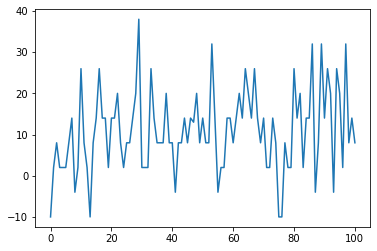

In [18]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(returns)

In [ ]:
eval_py_env._visualize_step = True

In [ ]:
step = 0
reward = tf.convert_to_tensor([0.])
time_step = eval_env.reset()
action_decode = eval_py_env.act.decode
action_code_list = list(eval_py_env.act.decode.values())
action_meaning_list = list(eval_py_env.act.decode.keys())
print('Init Bat @:')
print(eval_py_env.bat._tracker)
print('Obj Coordinates:')
print(eval_py_env.obj._coordinates)
print('FORMAT: FIGURE SHOW THE ACTIONS THAT IT TOOK THE NEXT STEP.\nTHE THEN TEXT SHOW THE SPECIFIC ACTION, BAT POSITION, AND REWARDS')
while not time_step.is_last():
    action_step = agent.policy.action(time_step)
    time_step = eval_env._step(action_step.action)
    reward += time_step.reward
    position = action_code_list.index(action_step.action.numpy()[0])
    print('action = '+ action_meaning_list[position], end='| ')
    print('bat @ (x,y)=({0},{1})'.format(np.round(eval_py_env.bat._tracker[0,0], 2), np.round(eval_py_env.bat._tracker[0,1], 2)), end='| ')
    print('angle={0}'.format(np.round(eval_py_env.bat._tracker[0,2],1)))
    print('Step='+str(eval_py_env.act.steps),end=' | ')
    print('episode_reward={0} | step_reward={1}'.format(reward.numpy()[0], time_step.reward.numpy()[0]))
    error_dist, error_azit = check_target_error(eval_py_env)
    print('distance={0}, azimuth={1}'.format(np.round(error_dist,2), np.round(error_azit, 2)))
print('Final Reward = '+str(reward.numpy()[0]))

In [ ]:
def check_target_error(environment):
    from coordinate_utils import polar_bat_reference

    food_xyk = environment.obj._coordinates[ environment.obj._coordinates[:,2]==1 ]
    food_polar = polar_bat_reference(food_xyk, environment.bat._tracker).reshape(2,)
    distance = food_polar[0]
    azimuth = food_polar[1] - environment.bat._tracker[0,2]
    azimuth = (azimuth - 360) if (azimuth>180) else (azimuth + 360) if (azimuth<-180) else azimuth
    return distance, azimuth

In [ ]:
error_dist, error_azit = check_target_error(eval_py_env)
print('distance={0}, azimuth={1}'.format(np.round(error_dist,2), np.round(error_azit, 2)))

In [ ]:
(error_dist<(0.2 + 0.15)) and (error_dist>0.2)

In [ ]:
eval_py_env.status.time_limit = 500

In [ ]:
from matplotlib import pyplot as plt
plt.scatter(range(eval_py_env.act.steps), eval_py_env.act.history)

In [ ]:
plt.hist(eval_py_env.act.history)

## EVALUATE SUCCESS RATE

In [ ]:
def compute_success_rate(environment, policy, num_episodes=100):
    success_count = 0
    for episode in range(num_episodes):
        time_step = environment._reset()
        episode_return = 0
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment._step(action_step.action)
        else:
            success_count += 1 if time_step.reward.numpy()[0]==50 else 0
        success_rate = success_count/num_episodes
    return success_rate

In [ ]:
eval_py_env._visualize_step = False
success = compute_success_rate(eval_env, agent.policy, 1000)
print('Success Rate = {0} %'.format(success*100))

In [19]:
def evaluation_record(environment, py_envi, policy, num_episodes=100):
    ending_decode = {'success': 0,
                     'hit_pole': 1,
                     'hit_plant': 2,
                     'timeout': 3,
                     'wormhole': 4}
    
    success_count = 0
    # Episode_id | case ID | obj0_x | ending | obj0_y | obj1_x | obj1_y | obj2_x | obj2_y 
    episode_details = np.array([]).reshape(0, 9)
    # Episode_id | action_index | bat_x | bat_y | bat_a | echo_100
    bat_records = np.array([]).reshape(0, 105)
    for episode in range(num_episodes):
        time_step = environment._reset()
        episode_return = 0
        case_id = np.where(py_envi.obj._coordinates==1)[0][0]
        obj0_x, obj0_y = (py_envi.obj._coordinates[0][0], py_envi.obj._coordinates[0][1])
        obj1_x, obj1_y = (py_envi.obj._coordinates[1][0], py_envi.obj._coordinates[1][1])
        obj2_x, obj2_y = (py_envi.obj._coordinates[2][0], py_envi.obj._coordinates[2][1])
        
        track = np.array([episode, py_envi.act.index, 
                          py_envi.bat._tracker[0,0], 
                          py_envi.bat._tracker[0,1],
                          py_envi.bat._tracker[0,2]])
        record = np.concatenate((track, py_envi.echo._echo)).reshape(1, 105)
        bat_records = np.vstack((bat_records, record))
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment._step(action_step.action)
            track = np.array([episode, py_envi.act.index, 
                          py_envi.bat._tracker[0,0], 
                          py_envi.bat._tracker[0,1],
                          py_envi.bat._tracker[0,2]])
            record = np.concatenate((track, py_envi.echo._echo)).reshape(1, 105)
            bat_records = np.vstack((bat_records, record))
        else:
            success_count += 1 if time_step.reward.numpy()[0]==50 else 0
            track = np.array([episode, py_envi.act.index, 
                          py_envi.bat._tracker[0,0], 
                          py_envi.bat._tracker[0,1],
                          py_envi.bat._tracker[0,2]])
            record = np.concatenate((track, py_envi.echo._echo)).reshape(1, 105)
            bat_records = np.vstack((bat_records, record))
            
            ending = 0 if time_step.reward.numpy()[0]==50 else py_envi.status.hit if py_envi.status.hit!=0 else 3 if py_envi.status.timeout else 4 if py_envi.status.wormhole else -1
            
        
        detail = np.array([episode, case_id, ending, obj0_x, obj0_y, obj1_x, obj1_y, obj2_x, obj2_y]).reshape(1,9)
        episode_details = np.vstack((episode_details, detail))
        
        
        
    success_rate = success_count/num_episodes
    return success_rate, episode_details, bat_records

In [20]:
eval_py_env._visualize_step = False
success, episode_details, records = evaluation_record(eval_env, eval_py_env, agent.policy, 3000)
print('Success Rate = {0} %'.format(success*100))

Success Rate = 33.6 %


In [22]:
np.savez('agent_checkpoints/simple_08.16.21_v1/evaluation_metrics.npz',
         training_avg_returns=np.array(returns),
         success_rate = np.array([success]),
         episode_details = episode_details,
         records = records)

In [21]:
import os

from tf_agents.policies import policy_saver

parent_dir = os.getcwd()
policy_dir = os.path.join(parent_dir, 'agent_checkpoints/simple_08.16.21_v1')
tf_policy_saver = policy_saver.PolicySaver(agent.policy)
tf_policy_saver.save(policy_dir)

INFO:tensorflow:Assets written to: /home/thinh/Sync/python-projects/echo_gym/echo_gym/pole_plant_env/agent_checkpoints/simple_08.16.21_v1/assets


INFO:tensorflow:Assets written to: /home/thinh/Sync/python-projects/echo_gym/echo_gym/pole_plant_env/agent_checkpoints/simple_08.16.21_v1/assets
